In [1]:
import os
os.system("python3.11 src/scrape_links.py")

running async fetches...
parsing all links...
dumping 438/444 links to file...


0

In [6]:
import os
os.system("python3.11 src/scrape_pages.py")

running async fetches...
parsing all pages...
dumping all pages...


0

In [164]:
from src.clean_data import get_cleaned_data

df = get_cleaned_data()
df

cleaning data...
removing 16 rows with price >= 150000...
removing 25 rows with invalid district...
final length: 397


,url,last_update,price,district,bag_of_words,neubau,area,rooms,needs_fix,leased
0,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 15:25:00,109000.0,1100,unbefristet vermietete wohnung in u-bahn nähe ...,False,48.55,NaN,None,True
1,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 09:20:00,149998.0,1100,u1-u-bahnnähe - >investitons - dachgeschosswoh...,True,41.28,1.0,True,False
2,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-04 13:56:00,129000.0,1100,urbanes wohnen in zentraler lage: gemütliche 1...,False,32.09,NaN,None,False
3,https://www.willhaben.at/iad/immobilien/d/eige...,2024-03-13 18:25:00,149000.0,1170,"altbauwohnung im erdgeschoss, ruhige gasse - s...",False,49.09,2.0,True,None
4,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-05 18:35:00,145000.0,1160,"klein, fein und hell: 1 zimmerwohnung im 4. li...",False,19.64,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...
433,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-07 15:35:00,136000.0,1100,top-preistop-preis die helle ca. 46 m² große ...,None,46.50,NaN,True,False
434,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-03 20:45:00,149000.0,1160,hervorragende gelegenheit! hochwertig sanierte...,False,32.71,1.0,False,None
435,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-05 10:39:00,129000.0,1100,schnäppchen in favoritenklein aber fein diese ...,None,41.00,2.0,None,None
436,https://www.willhaben.at/iad/immobilien/d/eige...,2024-04-01 07:04:00,129000.5,1160,charmante 1-zimmer wohnung im begehrten altbau...,False,35.87,1.0,False,False


# pick best options

In [165]:
import webbrowser
import pandas as pd


def remove_deal_breakers(df_arg: pd.DataFrame) -> pd.DataFrame:
    dfcpy = df_arg.copy()

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy['needs_fix'] != True]
    print(f"removed {prev_len - len(dfcpy)}: needs_fix == True")

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy['leased'] != True]
    print(f"removed {prev_len - len(dfcpy)}: leased == True")

    bad_words = [
        "unbefristet",
        "befristet",
        "renovierung",
        "sanierung",
    ]
    prev_len = len(dfcpy)
    for word in bad_words:
        dfcpy = dfcpy[~dfcpy['bag_of_words'].str.contains(word, case=False)]
    print(f"removed {prev_len - len(dfcpy)}: bag_of_words contains bad words")

    assert type(dfcpy) == pd.DataFrame
    return dfcpy


def remove_non_premium(df_arg: pd.DataFrame) -> pd.DataFrame:
    dfcpy = df_arg.copy()

    prev_len = len(dfcpy)
    dfcpy = dfcpy[dfcpy["neubau"] != False]
    print(f"removed {prev_len - len(dfcpy)}: neubau == (False, None)")

    assert type(dfcpy) == pd.DataFrame
    return dfcpy


dfcpy = remove_deal_breakers(df)
# dfcpy = remove_non_premium(dfcpy)
print("final count:", len(dfcpy))

dfcpy = dfcpy.sort_values(by='price', ascending=True) # type: ignore

urls = dfcpy['url'].tolist()
counter = 0
for url in urls:
    counter += 1
    print(f"progress {counter/len(urls)*100:.2f}%", end="\r")
    # webbrowser.open(url)



removed 99: needs_fix == True
removed 10: leased == True
removed 155: bag_of_words contains bad words
final count: 133


/var/folders/bh/4ympj4l52bs8wxpg114kdh1m0000gn/T/ipykernel_56864/645632954.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(df["last_update"].dt.strftime('%Y-%m-%d'), rotation=90, fontsize=7)


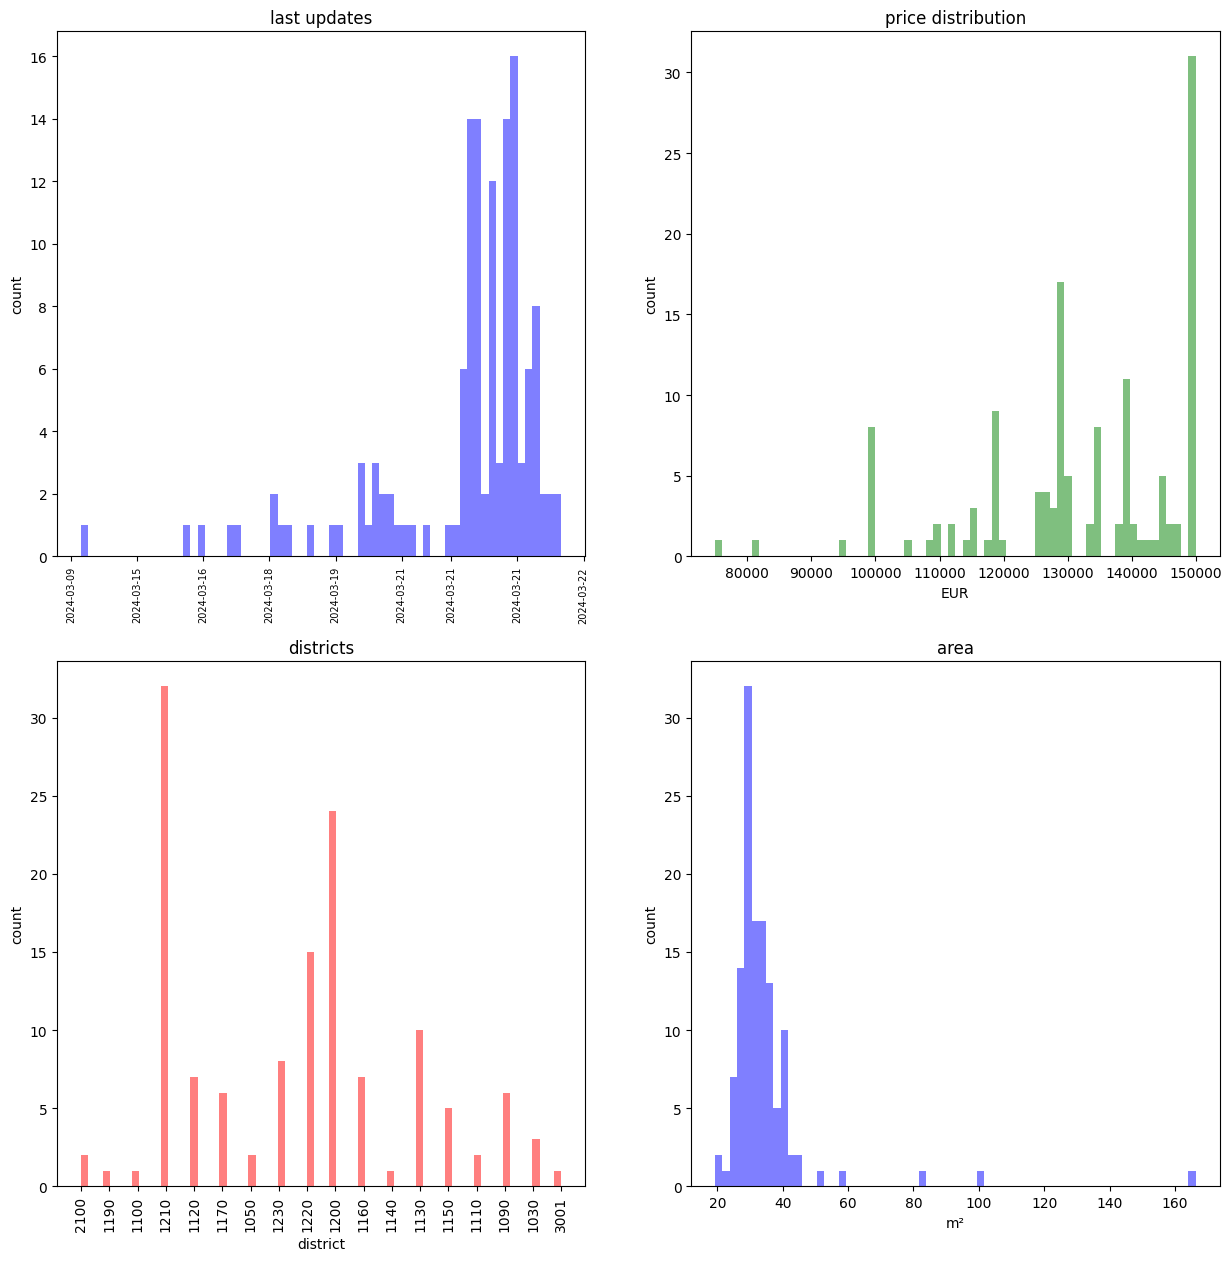

In [166]:
import matplotlib.pyplot as plt

df = dfcpy # comment out to use original df

fig, axs = plt.subplots(2, 2, figsize=(15, 15))


df = df.sort_values(by="last_update")
axs[0, 0].set_title("last updates")
axs[0, 0].hist(df["last_update"], bins=len(df) // 2, color="blue", alpha=0.5)
axs[0, 0].set_xticklabels(df["last_update"].dt.strftime('%Y-%m-%d'), rotation=90, fontsize=7)
axs[0, 0].set_ylabel("count")

axs[0, 1].set_title("price distribution")
axs[0, 1].hist(df["price"], bins=len(df) // 2, color="green", alpha=0.5)
axs[0, 1].set_xlabel("EUR")
axs[0, 1].set_ylabel("count")

axs[1, 0].set_title("districts")
axs[1, 0].hist(df.sort_values(by="district")["district"], bins=len(df) // 2, color="red", alpha=0.5)
axs[1, 0].set_xticks(range(len(df["district"].unique())))
axs[1, 0].set_xticklabels(df["district"].unique(), rotation=90)
axs[1, 0].set_xlabel("district")
axs[1, 0].set_ylabel("count")

axs[1, 1].set_title("area")
axs[1, 1].hist(df["area"], bins=len(df) // 2, color="blue", alpha=0.5)
axs[1, 1].set_xlabel("m²")
axs[1, 1].set_ylabel("count")

plt.show()